In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import casadi as cas
plt.style.use('seaborn')

/var/folders/lh/93lccf9x56l539tw7z9d404r0000gn/T/ipykernel_48996/418906186.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [44]:
n = 2
N = 10
dt = 10
TOL = 1e-4
opti = cas.Opti()
X = opti.variable(n, N+1)
U = opti.variable(n, N)
C = np.zeros((n,n))

x0 = np.array([100, 100])
u0 = np.array([1, 0])
ks = 1
kh = 0.5
alpha = 100 # Penalty on switching
C = np.array([[ks + kh, ks], [ks, ks + kh]])

cost = 0
for i in range(N):
    consumption =  C @ U[:, i] * dt
    
    #consumption += cas.if_else(cas.sumsqr(U[:,i] - U[:, i-1]) > TOL, U[:,i] * alpha * dt,  0)
    # cost += cas.if_else(cas.sumsqr(U[:,i] - U[:, i-1]) > TOL, 100,  0)

    cost -= 10* cas.sumsqr(X[0,i] - X[1,i]) 

    opti.subject_to(X[:,i+1] == X[:,i] - consumption)
    # opti.subject_to(U[0,i]**2 + U[1,i]**2 == 1)
    opti.subject_to( cas.mmax(U[:,i]) == 1)
    opti.subject_to( cas.mmin(U[:,i]) == 0)


In [45]:
opti.minimize(cost)
opti.subject_to(X[:, 0] == x0)
opti.set_initial(U, np.ones((n, N)))
p_opts = {"expand":True}
s_opts = {"max_iter": 10000}

opti.solver('ipopt', p_opts, s_opts)

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      122
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       42
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 1.00e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [46]:
np.round(sol.value(U),0)

array([[1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
       [0., 1., 1., 0., 1., 0., 1., 1., 0., 1.]])

In [47]:
sol.value(U)

array([[1.00000000e+00, 3.04760889e-09, 2.89951931e-09, 1.00000000e+00,
        2.41362313e-09, 1.00000000e+00, 1.73040746e-09, 1.33747037e-09,
        1.00000000e+00, 4.91400096e-10],
       [3.33136427e-09, 1.00000000e+00, 1.00000000e+00, 2.85432840e-09,
        1.00000000e+00, 2.20343969e-09, 1.00000000e+00, 1.00000000e+00,
        9.10014889e-10, 1.00000000e+00]])

In [48]:
opti.value(cost)

-2250.000003019957

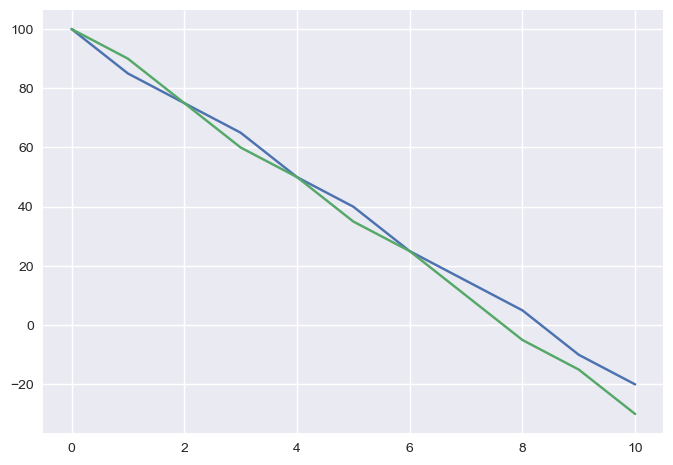

In [49]:
x1 = sol.value(X)[0,:]
x2 = sol.value(X)[1,:]
plt.plot(x1)
plt.plot(x2)


In [174]:
# QP Formulation
S = 1000
ks = [1, 1, 1, 0.5, 0.5, 0.5]
kh = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
n = 6

opti2 = cas.Opti()
U = opti2.variable(n*2)

C = np.zeros((2*n, 2*n))

for j in range(2*n):
    C[0, j] = 1 if (j % 2 == 0  and j + 2 != 2*n) else 0
    C[0, -1] = -1

for i in range(n - 1):
    for j in range(2 * n):
        if j == 2*i + 1:
            C[i + 1,j] = -1
        elif j % 2 == 0 and j != 2*i:
            C[i + 1,j] = 1

for i in range(0, n):
    for j in range(2*i, 2*n):
        C[n + i, j : j + 2] = np.array([1,1])
        break

b = np.zeros((2*n))
b[n:] = np.ones(n) * S

B = np.zeros((n, 2* n))
for i in range(0, n):
    for j in range(2*i, 2*n):
        B[i, j : j + 2] = np.array([kh[i] + ks[i], ks[i]])
        break

L = np.ones(n) * 100

life = L - B @ U

opti2.subject_to( C @ U - b == 0)
opti2.subject_to( U >= np.zeros((n*2,1)))

opti2.minimize(cas.sumsqr( cas.diff(life) ) )
# opti2.minimize(cas.sumsqr(B @ U)) 

p_opts = {"expand":True}
s_opts = {"max_iter": 10000}
opti2.solver('ipopt', p_opts, s_opts)

sol = opti2.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       48
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:       38

Total number of variables............................:       12
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:       12
        inequality constraints with only lower bounds:       12
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+03 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [175]:
sol.value(U)

array([3.95996138e-05, 9.99999960e+02, 3.96081812e-05, 9.99999960e+02,
       9.89047582e-06, 9.99999990e+02, 5.71428544e+02, 4.28571456e+02,
       2.85714251e+02, 7.14285749e+02, 1.42857115e+02, 8.57142885e+02])

In [162]:
B = np.zeros((n, 2* n))
for i in range(0, n):
    for j in range(2*i, 2*n):
        B[i, j : j + 2] = np.array([kh + ks, ks])
        break

In [163]:
B

array([[1.5, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1.5, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1.5, 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1.5, 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.5, 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.5, 1. ]])

In [126]:
C[n+i, 0:2] = np.array([1,1])

11